# [0] Imports

In [3]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

# [1] Setup

## [1a] Initialize variables
Many parameters need to be set up and initialized so they can be called upon later in the code according to the Overleaf document.

In [4]:
n_jobs = 25
n_vehicles_jobs = 15
n_vehicles_coverage = 10

#Optimization over 6 hours with a time-step of 10 minutes, T = # of timesteps
T = 50

#=
The following definitions help with code for our problem
and are not found in the formulation, 
but indirectly necessary when calculated by parameters
=#

#Minimal length of a job is two-time period
min_duration = 2
max_duration = 6
#Speed is in m/10minutes = m/interval
speed = 1000/6
#Radius for coverage is 50m
coverage_distance = 50
#Size of the square for jobs location in meters
size = 500
#Size of the mesh for the coverage vehicles locations
step = 50;

## [1b] Create locations and time-windows 

I will put many of these initialization parts into functions.

We create clusters to beautify the problem - rather than truly random task locations we give it some structure. This is just an element of our artificial data!

In [5]:
# We set the seed so that we always have the same result
Random.seed!(1234)

#=
Our 'creative' strategy is to create jobs in small clusters.
Then, for each cluster, we include some variation on the locations
of the job.
=#

function create_cluster_sizes(jobs_total)
    #=
    Given a total number of jobs we need to create, 
    creates cluster SIZES. For instance, if we have 15 jobs,
    one possible output is 3, 4, 5, 3.
    
    returns cluster, which is an array listing the sizes of clusters.
    =#
    Random.seed!(1234)
    jobs_created = 0
    cluster = []
    while jobs_created != jobs_total
        num_to_add = rand(min(3, jobs_total - jobs_created) : 
            min(Int((n_jobs/5)÷1), jobs_total - jobs_created))
        jobs_created += num_to_add
        push!(cluster, num_to_add)
    end
    
    return cluster
end

create_cluster_sizes (generic function with 1 method)

In [6]:
# Create job and depot locations, time windows and work load for each job.
time_windows = []
locations = rand(Uniform(0,size), 1, 2)
work_load = []
#=
time_windows is a list of tuples, with each tuple [s, e] specifying
when a job must be performed, between s and e inclusive.

work_load represents the duration of the job.

time_windows tuple is the ONLY time the job can be completed.
The job must be completed sometime *within* time_windows tuple.

Note that sometimes, the tuple specifies exactly the time
when we must work at that job, while other times,
there is more flexibility because the tuple is particularly long
compared to the work_load duration.
=#

cluster = create_cluster_sizes(n_jobs)

7-element Vector{Any}:
 3
 4
 3
 5
 4
 4
 2

### Function to Create Time Windows and Work Load

Critical parameters for the algorithm later on. We will create both the time windows allotted, as well as the time it takes to finish each job.

In [7]:
function create_time_windows_and_work_load(cluster_sizes, locations)
    #=
    parameters to pass in.
    Realistically these should be put as parameters in the function 
    signature, but we can do this for ease...nothing too bad
    
    Returns time windows of the form [ [start, end], ...]
    work_load of the durations of each job e.g. [5, 6, 4..]
    locations
    =#
    Random.seed!(1234)
    locations = rand(Uniform(0,size), 1, 2)
    for size_c in cluster
        first = rand(Uniform(0,size), 1, 2)
        locations = vcat(locations, first)

        job_begins = rand(2:10)
        job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
        push!(time_windows, [job_begins, job_finish])

        time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
        push!(work_load, time_work)

        for neighbour in 1:(size_c-1)
            new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
            new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
            new = hcat(new_x, new_y)
            locations = vcat(locations, new)

            job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
            job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
            push!(work_load, time_work)
        end
    end
    
    return [time_windows, work_load, locations]
end

create_time_windows_and_work_load (generic function with 1 method)

In [8]:
time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)
#=
now, 

time_windows looks like [ [8, 10], [16, 21], ... , [16, 21]]

work_load looks like [2, 5, 2, 4, 2, 2, ..., 2, 5]
=#

#Compute distances between each locations created
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

println("Time Windows")
for time_window in time_windows
    println(time_window)
end

println("Work Loads ", work_load)

Time Windows
[5, 8]
[13, 17]
[20, 25]
[8, 10]
[14, 17]
[22, 26]
[30, 35]
[2, 8]
[11, 14]
[18, 22]
[9, 13]
[14, 17]
[21, 24]
[27, 29]
[31, 37]
[2, 5]
[8, 10]
[12, 17]
[17, 21]
[10, 14]
[15, 20]
[24, 27]
[27, 33]
[4, 9]
[9, 15]
Work Loads Any[3, 4, 5, 2, 2, 3, 4, 3, 2, 4, 4, 3, 3, 2, 5, 3, 2, 3, 3, 3, 4, 2, 3, 4, 5]


In [9]:
# locations - these are Cartesian coordinates telling us where stations are in the plane
print("Locations: ", locations, "\n")

Locations: [162.98836443179744 274.5255681577834; 109.29332740941533 447.12271410049414; 121.1152053108041 446.89270877611096; 89.59124765472993 435.09777866446035; 323.92765788592794 498.332645718842; 326.53347225637947 483.83207561135157; 328.32265251259605 492.9102875883275; 309.1686841347623 498.8397830821424; 36.35807104610789 350.5579177570377; 47.090405717384044 341.3203068534036; 55.48085983316444 364.68758998092676; 260.3707024335765 470.9155090761928; 260.37715114996485 479.54934664105195; 247.26012681195274 464.00956357114217; 240.48176081945687 456.302922303405; 276.6482779863586 455.5862703353655; 239.93121460946887 474.9841599335543; 251.64446751105916 493.673348915355; 246.70672450784087 490.66852195024524; 232.51197192211055 487.17296281307057; 244.46684180873675 245.79037260667468; 225.94275471532777 256.0041140341042; 231.9341041485549 256.19089982535576; 241.8876807998831 230.46206318844872; 73.90222246114125 139.66111885815096; 65.10392466179182 147.0898582966076]


### A little exercise: plot the task locations

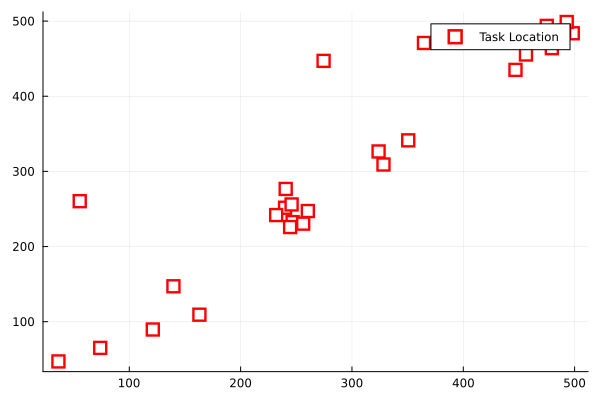

In [10]:
# let's do a little JuMP exercise of plotting the locations.
x_values = []
y_values = []
for i in 1:Int(length(locations) / 2)
    push!(x_values, locations[i * 2 - 1])
    push!(y_values, locations[i*2])
end

Plots.scatter(x_values, y_values; label = "Task Location", markershape = :square, 
markercolor = :white, markersize = 6, markerstrokecolor = :red, markerstrokewidth = 3)

In [11]:
# normalization and checking: make sure that T is truly the largest we need
max_t = 0
for window in time_windows
    if window[2] > max_t
        max_t = window[2]
    end
end
T = min(50, max_t + 8);
#T is still 50

print("T is ", T)

T is 45

## [1c] Create the time-space network for jobs

### Create node network

In [12]:
#=
Create the node network

This will be of the form
[ [location, time] ...]

which is a full rendition of all possible 
locations and times

so there will be (total time - 2) * location
nodes.

This will create a time-space network not including
the very first and very last time,
because those have time 1 = location 0 and time 50 = location 26
by default. So we don't need to put it in here.
=#
function create_node_network(n_jobs, T)
    nodes = []
    for i in 1:n_jobs
        for t in 2:(T-1)
            push!(nodes, [i, t])
        end
    end
    return nodes
end

create_node_network (generic function with 1 method)

### Create Arc System

This is more complicated and involves three stages.

First: leaving the depot

Second: between jobs

Third: coming back into the depot.

It is assumed that no vehicle will do depot -> job -> depot -> job...
because it is inefficient. 

We just go depot -> job -> back to depot.
(job can consist of multiple jobs)

In [13]:
function create_arc_system(n_jobs, distances, speed, time_windows, nodes)
    #=
    Create a full arc system which has the format
    [ [initial_i, initial_t], [end_i, end_t], distance]
    
    remember: distance is like our cost, the first two elements represent the movement
    =#
    
    arcs = []
    
    #leaving the depot
    for n in nodes
        dist = distances[1, n[1] + 1]
        max_t = 0
        for t in 1:n[2]
            if n[2] > (t + dist/speed)
                max_t = t
            end
        end
        push!(arcs, [[0, max_t], n, dist])
    end
    
    #between two jobs
    for n1 in nodes
        already = []
        for n2 in nodes
            dist = distances[n1[1]+1, n2[1]+1]
            
            #=
            only add arc from node n1 = [i1, t1] to n2 = [i2, t2] if:
            1) it is possible to get from n1 to n2 within the given timeframe (time = dist / speed)
            2) the nodes do not have the same job location - this is covered in elseif
            3) n2 is not already covered in our node network - it won't be a superfluous addition
            4) n2's time is worth going to: we have enough time left to get there to do the job
            
            condition 4 example: If current time is 15, time window is [13, 20], and the work load 
            (time required) is 6 hours, then don't bother going to the job - it's a waste of time
            =#
            if (n2[2] > n1[2] + dist/speed) & 
                (n2[1] != n1[1]) & 
                (!(n2[1] in  already)) & 
                (n2[2] <= (time_windows[n2[1]][2] - work_load[n2[1]]))
                push!(arcs, [n1, n2, dist])
                push!(already, n2[1]) #already visited so we don't do it again: algorithmic efficiency
                
            elseif (n2[2] == n1[2] + 1) & (n2[1] == n1[1])
                push!(arcs, [n1, n2, dist])
                
            end
        end
    end
    
    #Back to the depot
    for n in nodes
        dist = distances[1, n[1] + 1]
        min_t = T+1
        for t in T:-1:1
            if t > (n[2]+dist/speed)
                min_t = t
            end
        end
        push!(arcs, [n, [n_jobs+1, min_t], dist])
    end
    
    #Now, add intra-depot arcs to minimize drivers necessary
    push!(arcs, [[0,1], [n_jobs+1, 2], 0])
    
    #finally, arcs is ready
    
    return arcs
end

create_arc_system (generic function with 1 method)

In [14]:
nodes = create_node_network(n_jobs, T)
arcs = create_arc_system(n_jobs, distances, speed, time_windows, nodes)

N = length(nodes)
A = length(arcs)

println("Number of nodes: ", length(nodes))
println("Number of arcs: ", length(arcs))

#=
Arcs are represented in the format
[ [initial_i, initial_t], [after_i, after_t], distance]

so
arc[1] = tuple of initial (i, t)
arc[2] = tuple of after (i, t)
arc[3] = distance traveled

and then arcs is a list of these arcs
=#

Number of nodes: 1075
Number of arcs: 11012


In [15]:
# sample some of the arcs
println("A sampling of arcs")
for i in [round(Int, A * 0.2), round(Int, A * 0.5), round(Int, A * 0.9)]
    println("Arc number ", i, " is ", arcs[i])
end

A sampling of arcs
Arc number 2202 is Any[[4, 3], [19, 4], 92.09433295698844]
Arc number 5506 is Any[[13, 8], [12, 9], 20.335712068768498]
Arc number 9911 is Any[[25, 26], [23, 28], 195.45695429638533]


## [1d] Create Coverage System

This is the same thing as what we did before, except instead for task vehicles, we do it for coverage vehicles.

Our first order of business is to identify all jobs which weren't covered by coverage vehicles given a coverage set. The function works as follows.

First, given a `set_coverage` which indicates where the vehicle is placed. Then, for all jobs, we suppose it's not covered. For the coverage vehicle possibilities, we see if among all coverage vehicles, there exists one whose coverage radius emanates sufficiently outward to encapsulate that location. If so, then we say it is covered; otherwise, it's not.

If a job isn't covered, indicate so, and return.

In [16]:
function find_not_covered(set_coverage)
    jobs_not_covered = []
    for job in 1:n_jobs
        covered_job = false
        for j in 2:n_cov
            if LinearAlgebra.norm(set_coverage[j] .- locations[job+1,:]) <= coverage_distance
                covered_job = true
            end
        end
    
        if !(covered_job)
            push!(jobs_not_covered, job)
        end
    end
    return jobs_not_covered
end

find_not_covered (generic function with 1 method)

### Create Coverage Location Array

Now, we need to initialize a coverage array by determining where the coverage stations will be. This initialization can be compared with the initialization system for task locations in section 1b.

In [17]:
locations_array = [[locations[i,1], locations[i,2]] for i in 1:(n_jobs+1)]
#=
locations_array restyles locations in a better format that gives
a list of tuples. then we take the first one to be our primary coverage location
and then we add to it.
=#

println("Locations array is: ", locations_array)
hull = convex_hull(locations_array)

println()

coverage_locations = [[locations[1, 1], locations[1, 2]]]
println("Initialized coverage locations are: ", coverage_locations)

Locations array is: [[162.98836443179744, 274.5255681577834], [109.29332740941533, 447.12271410049414], [121.1152053108041, 446.89270877611096], [89.59124765472993, 435.09777866446035], [323.92765788592794, 498.332645718842], [326.53347225637947, 483.83207561135157], [328.32265251259605, 492.9102875883275], [309.1686841347623, 498.8397830821424], [36.35807104610789, 350.5579177570377], [47.090405717384044, 341.3203068534036], [55.48085983316444, 364.68758998092676], [260.3707024335765, 470.9155090761928], [260.37715114996485, 479.54934664105195], [247.26012681195274, 464.00956357114217], [240.48176081945687, 456.302922303405], [276.6482779863586, 455.5862703353655], [239.93121460946887, 474.9841599335543], [251.64446751105916, 493.673348915355], [246.70672450784087, 490.66852195024524], [232.51197192211055, 487.17296281307057], [244.46684180873675, 245.79037260667468], [225.94275471532777, 256.0041140341042], [231.9341041485549, 256.19089982535576], [241.8876807998831, 230.462063188448

In [18]:
function establish_coverage_locations(coverage_locations)
    #=
    Given some parameters including initial coverage locations, as well as:
    size (of mesh)
    step (within mesh)
    coverage_distance (how wide the radius is for a coverage vehicle)
    
    create a system of coverage locations of where we can possibly be.
    
    In other words, we are given the job/task locations FIRST. Then,
    we will decide which discrete coverage locations we will have as 
    possibilities for the coverage.
    =#
    for i in 0:(size/step)
        for j in 0:(size/step)
            x = i*step
            y = j*step
            # assume that the coverage location is useless.
            useful = false
            for job in 1:n_jobs
                if (LinearAlgebra.norm([x,y] .- locations[job+1,:]) <= coverage_distance) & 
                    (element(Singleton([x,y])) ∈ VPolygon(hull))
                    useful = true
                end
            end
            if useful
                push!(coverage_locations, [x,y])
            end
        end
    end
    
    return coverage_locations
end
coverage_locations = establish_coverage_locations(coverage_locations)

println("Coverage locations after establishment: ", coverage_locations)

n_cov = length(coverage_locations)
println("Number of coverage locations: ", n_cov)

Coverage locations after establishment: [[162.98836443179744, 274.5255681577834], [50.0, 300.0], [50.0, 350.0], [100.0, 350.0], [100.0, 400.0], [150.0, 450.0], [200.0, 250.0], [200.0, 450.0], [250.0, 300.0], [250.0, 450.0], [300.0, 450.0]]
Number of coverage locations: 11


Now we have successfully defined coverage locations.

What we need to do is to see if there are any jobs uncovered.

In [19]:
jobs_not_covered = find_not_covered(coverage_locations)

#this is going to be problematic: if we don't have something close enough, create a new one
for job in jobs_not_covered
    println("Job ", job, " is uncovered!")
    loc = locations[job + 1, :]
    new_x = round(loc[1]/25)*25
    new_y = round(loc[2]/25)*25
    if !([new_x, new_y] in coverage_locations)
        push!(coverage_locations, [new_x, new_y])
    end
end

#see if anything changes
n_cov = length(coverage_locations)
println("Now, we have ", n_cov, " locations.")
println("They are: ", coverage_locations)

Job 4 is uncovered!
Job 6 is uncovered!
Job 24 is uncovered!
Job 25 is uncovered!
Now, we have 13 locations.
They are: [[162.98836443179744, 274.5255681577834], [50.0, 300.0], [50.0, 350.0], [100.0, 350.0], [100.0, 400.0], [150.0, 450.0], [200.0, 250.0], [200.0, 450.0], [250.0, 300.0], [250.0, 450.0], [300.0, 450.0], [325.0, 500.0], [75.0, 150.0]]


In [20]:
#=
We create a matrix of how distant coverage locations are to EACH OTHER.
=#
coverage_distances = [LinearAlgebra.norm(coverage_locations[i] .- coverage_locations[j]) 
    for i=1:length(coverage_locations), j = 1:length(coverage_locations)]

13×13 Matrix{Float64}:
   0.0     115.825   135.878    98.3053  …  222.629   277.645   152.475
 115.825     0.0      50.0      70.7107     291.548   340.037   152.069
 135.878    50.0       0.0      50.0        269.258   313.249   201.556
  98.3053   70.7107   50.0       0.0        223.607   270.416   201.556
 140.397   111.803    70.7107   50.0        206.155   246.221   251.247
 175.954   180.278   141.421   111.803   …  150.0     182.003   309.233
  44.4001  158.114   180.278   141.421      223.607   279.508   160.078
 179.335   212.132   180.278   141.421      100.0     134.629   325.0
  90.6641  200.0     206.155   158.114      158.114   213.6     230.489
 195.863   250.0     223.607   180.278       50.0      90.1388  347.311
 222.629   291.548   269.258   223.607   …    0.0      55.9017  375.0
 277.645   340.037   313.249   270.416       55.9017    0.0     430.116
 152.475   152.069   201.556   201.556      375.0     430.116     0.0

## [1e] Create Node and Arc Systems for COVERAGE

Analogous to 1c.

For the Node Network

In [21]:
#=
This is analogous to what we do above. 
=#
function create_cov_node_network(n_cov)
    #=
    Given a number of coverage nodes, creates a full 
    coverage network in similar fashion to what
    we did in 1c.
    =#
    nodes_cov = []
    for i in 1:(n_cov-1)
        for t in 2:(T-1)
            push!(nodes_cov, [i,t])
        end
    end
    return nodes_cov
end

create_cov_node_network (generic function with 1 method)

For the Arc System

In [22]:
function create_cov_arc_system(n_cov, coverage_distances, speed, nodes_cov)
    #=
    in utility this is very similar to our creation of the arc system
    for TASK vehicles, except we now don't need to care about respecting
    time windows for a parameter simplification.
    
    as a result, the time_windows parameter is unnecessary.
    =#
    arcs_cov = []
    
    #Leaving the Depot: time is always equal to 0 here
    for n in nodes_cov
        dist = coverage_distances[1, n[1] + 1]
        max_t = 0
        for t in 1:n[2]
           if n[2] > (t + dist/speed)
                max_t = t
            end
        end
        push!(arcs_cov, [[0, max_t], n, dist])
    end

    #Between two coverage locations
    for n1 in nodes_cov
        already = []
        for n2 in nodes_cov
            dist = coverage_distances[n1[1]+1, n2[1]+1] 
            if (n2[2] > n1[2] + dist/speed) & (n2[1] != n1[1]) & !(n2[1] in already)
                push!(arcs_cov, [n1, n2, dist])
                push!(already, n2[1])
            elseif (n2[2] == n1[2] + 1) & (n2[1] == n1[1])
                push!(arcs_cov, [n1, n2, dist])
            end
        end
    end

    #Back to the depot: time is always T+1 = 51 in this case here
    for n in nodes_cov
        dist = coverage_distances[1, n[1] + 1]
        min_t = T+1
        for t in T:-1:1
            if t > (n[2]+dist/speed)
                min_t = t
            end
        end
        push!(arcs_cov, [n, [n_cov, min_t], dist])
    end
    
    return arcs_cov
end

nodes_cov = create_cov_node_network(n_cov)
arcs_cov = create_cov_arc_system(n_cov, coverage_distances, speed, nodes_cov)

#have a final arc
push!(arcs_cov, [[0,1], [n_cov, 2], 0])

N_cov = length(nodes_cov)
A_cov = length(arcs_cov)

println("Our node system has size ", N_cov)
println("Our arcs system has size ", A_cov)

#do a sampling
for i in [51, 163, 252, 353]
    println("Arc ", i, " is ", arcs_cov[i])
end

Our node system has size 516
Our arcs system has size 7001
Arc 51 is Any[[0, 8], [2, 9], 135.87774048341421]
Arc 163 is Any[[0, 34], [4, 35], 140.39717625337047]
Arc 252 is Any[[0, 37], [6, 38], 44.40005248753111]
Arc 353 is Any[[0, 8], [9, 10], 195.8629647345368]


Check to make sure what has been covered is covered: this appears later in a few optimization constraints and will be needed later.

<b>This will take a bit of time!</b>

In [23]:
covers = Dict()
for n in 1:N
    covers[n] = []
    for a in 1:A_cov
        arc_start = arcs_cov[a][1][1]
        time_start = arcs_cov[a][1][2]
        arc_end = arcs_cov[a][2][1]
        if (arc_end != n_cov)
            if (time_start == nodes[n][2]) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_start+1]) <= coverage_distance) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_end+1]) <= coverage_distance)
                push!(covers[n], a)
            end
        else
            if (time_start == nodes[n][2]) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[arc_start+1]) <= coverage_distance) & (LinearAlgebra.norm(locations[nodes[n][1]+1,:] .- coverage_locations[1]) <= coverage_distance)
                push!(covers[n], a)
            end
        end
    end
end

In [24]:
not_covered = []
for j in 2:(n_jobs+1)
    covered_j = false
    for n in 1:N
        if ((j-1) == nodes[n][1]) & (length(covers[n]) > 0)
            # println("Job ", j-1, " is covered")
            covered_j = true
            break
        end
    end
    if !covered_j
        # println("Job ", j-1, " is not covered")
        push!(not_covered, j)
    end
end 

#=
after running these 5 cells, we get all jobs are covered!
=#

We can draw a diagram of this scenario.

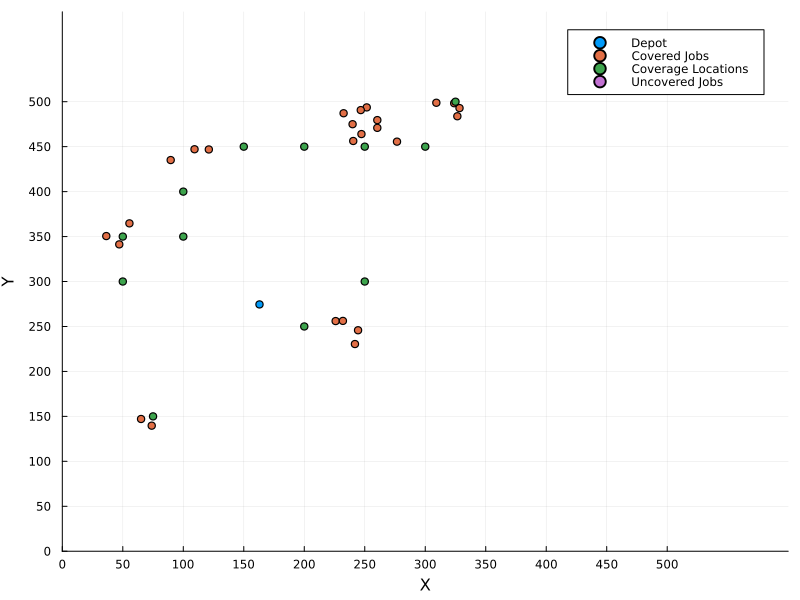

In [25]:
scatter([[locations[1, 1]], locations[2:n_jobs+1, 1], [coverage_locations[i][1] for i in 2:length(coverage_locations)], [locations[i, 1] for i in not_covered]],
        [[locations[1, 2]], locations[2:n_jobs+1, 2], [coverage_locations[i][2] for i in 2:length(coverage_locations)], [locations[i, 2] for i in not_covered]], 
        label = ["Depot" "Covered Jobs" "Coverage Locations" "Uncovered Jobs"],
        xlabel = "X", ylabel = "Y", xlim = (0,600), ylim = (0,600), size = (800,600), xticks = 0:50:500, yticks = 0:50:500)


## [1f] Helper Functions

We will define a few helper functions to obtain necessary data, which will be used in the formualtion.

In [26]:
function find_node(i,t)
    #=
    Given a task location and a time, see if there exists
    a node with that definition. If so, then return that node.
    Otherwise, warn the user.
    =#
    for node in 1:length(nodes)
        if (nodes[node][1] == i) & (nodes[node][2] == t) 
            return node
        end
    end
    return "Warning, this node does not exist"
end

find_node (generic function with 1 method)

In [27]:
function find_arc(node, t)
    #=
    Similar principle to above. Given a node and a time, 
    see if there exists an ARC that starts and ends with that node
    and goes from time t to t+1.
    
    This is looking for specialized arcs...just forgot off the top
    of my head
    =#
    for arc in 1:length(arcs)
        if (arcs[arc][1][1] == node) & (arcs[arc][2][1] == node) & ((arcs[arc][1][2] == t)) & ((arcs[arc][2][2] == t+1))
            return arc
        end
    end
    return (node, t), "Warning, this arc does not exist"
end

find_arc (generic function with 1 method)

# [2] Direct Formulation Model

Now that we have finished initializing all the elements, we can build our "straightforward" model which directly computes the answer for us. No column generation, no set partitioning... nothing.

In [28]:
#these were written in section 1 but I am rehashing them here
n_vehicles_coverage = 10
n_vehicles_jobs = 15

#=
n_vehicles_coverage is equivalent to the number of 
total vehicles and can be considered with subscript k.

n_vehicles_jobs is equivalent to the number of total coverage
vehicles.
=#

15

In [29]:
model = Model(Gurobi.Optimizer);
#model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=100));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


## [2a] Decision Variables

There are 5 sets of decision variables.

Coverage vehicle assignments: $x_{ka}$ if a coverage vehicle $k \in \mathcal{K}'$ contains coverage arc $a \in \mathcal{A}'$ in its path

Job vehicle assignments: $z_{ka}$ if a task vehicle $k \in \mathcal{K}$ contains task arc $a \in \mathcal{A}$ in its path

Job start and end times: $y^S_{it}$/$y_{it}^E$ with $1$ if a job's start/end has taken place by that time (so this is an array like \[ 0, 0, ...., 1, 1, ..., 1\] and the differential will tell us when the job is taking place, it will look like \[ 0, 0, ..., 1, 1, ..., 0, 0\]

Coverage: $\gamma_{it}$ if node $(i, t) = n \in \mathcal{N}$ is covered at that time. In other words, if in place $i$ and time $t$, there is a coverage vehicle which is close enough to radially overlap onto location $i$.

In [30]:
#Coverage vehicles
@variable(model, x[1:n_vehicles_coverage, 1:A_cov], Bin)

#Job Vehicles
@variable(model, z[1:n_vehicles_jobs, 1:A], Bin)

#Starting and ending times of each Job
@variable(model, y_s[1:n_jobs, 1:T], Bin)
@variable(model, y_e[1:n_jobs, 1:T], Bin)

#Coverage constraint
@variable(model, gamma[1:N], Bin);

## [2b] Objective Function

Minimize the total distance traveled by the coverage and job vehicles together.

Distance by coverage vehicles: $\sum_{k \in \mathcal{K}'} \sum_{a \in \mathcal{A}'} c_a' x_{ka}$

Distance by task vehicles: $\sum_{k \in \mathcal{K}} \sum_{a \in \mathcal{A}} c_a z_{ka}$

To find distances, get the third element: `arcs[?][3]` (for task vehicles) and `arcs_cov[?][3]` (for coverage vehicles)

In [31]:
@objective(model, Min, sum(sum(x[k,a]*(arcs_cov[a][3]+1) for a in 1:A_cov) for k in 1:n_vehicles_coverage) 
    + sum(sum(z[k,a]*(arcs[a][3]+1) for a in 1:A) for k in 1:n_vehicles_jobs))
;

## [2c] Constraints

### Constraints for jobs vehicles (4)

- Consider some vehicle $k \in \mathcal{K}$. Then, the number of times that vehicle leaves the depot (to do work) must be 1. In other words, the vehicle leaves the depot, but doesn't leave twice (meaning if you're out there, you stay out there). It is formulated as: For all possible times $t$ when the vehicle $k$ leaves, i.e. for the sum over all nodes of the form $(0, t)$ (i.e. you are at the depot at any given time $t$, not yet having left the depot), for the sum over all arcs $a \in \mathcal{A}^+((0, t))$ (the arcs that make exiting the depot possible), there is exactly one time when you do leave the depot. So the constraint is $\sum_{n \in \mathcal{O}} \sum_{a \in \mathcal{A}^+(n)} z_{ka} = 1 \ \forall k \in \mathcal{K}$.

To actualize this constraint, take the sum over all arcs, but only if their initial location $i$ is $0$. Remember that arcs are of the form $[n_1 = (i_1, t_1), n_2 = (i_2, t_2), d]$, and we have to make sure that the arc element 1 index 1 is equal to 0.

In [32]:
@constraint(model, 
    depot_init_jobs[k in 1:n_vehicles_jobs], 
    sum(z[k,a] for a in 1:A if arcs[a][1][1] == 0) == 1)
print()

- Do the same, but for entering back into the depot after you've done work. The number of times you come back into the depot must be equal to exactly 1. Similarly, our constraint will be $\sum_{n \in \mathcal{E}} \sum_{a \in \mathcal{A}^-(n)} z_{ka} = 1 \ \forall k \in \mathcal{K}$.

To actualize this constraint, take the sum over all arcs, but only if their end location $i$ is $0$. Remember that arcs are of the form $[n_1 = (i_1, t_1), n_2 = (i_2, t_2), d]$, and we have to make sure that the arc element 2 index 1 is equal to 0.

In [33]:
@constraint(model, 
    depot_end_jobs[k in 1:n_vehicles_jobs], 
    sum(z[k,a] for a in 1:A if arcs[a][2][1] == n_jobs+1) == 1)
print()

What about the case in which our vehicle doesn't even move because doing so would be suboptimal? Well, it would have a single arc that goes from $(0, 0)$ to $(n+1, T+1)$ so it's still fine.

- Now we consider nodes that aren't in the depot, or the set $\mathcal{N} - \mathcal{O} - \mathcal{E}$. We need flow conservation, meaning for any vehicle that enters a node, it must eventually leave. In other words, what goes in, which is $\sum_{a \in \mathcal{A}^-(n)} z_{ka}$, must eventually come out, which is $\sum_{a \in \mathcal{A}^+(n)} z_{ka}$. These two must be equal, so the full constraint is: $\forall k \in \mathcal{K}, \ \forall n \in \mathcal{N} - \mathcal{O} - \mathcal{E}, \ \sum_{a \in \mathcal{A}^-(n)} z_{ka} = \sum_{a \in \mathcal{A}^+(n)} z_{ka}$.

<b>Now we see why `nodes` deliberately excluded nodes of the form $(0, ?)$ and $(T+1, ?)$.</b> It's because we use the set $\mathcal{N} - \mathcal{O} - \mathcal{E}$ a lot, so it's hard to define `nodes` as all of the nodes, then we have to subtract all nodes in the depot.

To actualize this constraint, check that, for all arcs for which the second arc array index (incoming is equal to $n$) is $n$ the summation equals over all arcs for which the first arc array index (outgoing is equal to $n$) is $n$.

Note that there is no need to worry about whether an arc stays at the same place in time, because the equality is still maintained, so we don't need an exclusive check.

In [34]:
# SLOW CONSTRAINT!
@constraint(model, 
    flow_jobs[k in 1:n_vehicles_jobs, n in 1:N], 
    sum(z[k,a] for a in 1:A if arcs[a][2] == nodes[n]) == 
    sum(z[k,a] for a in 1:A if arcs[a][1] == nodes[n]))
print()

Finally, consider every node that's not in the depot. Only ONE vehicle should visit that node to do a job; don't split jobs between different task vehicles.

So for all nodes, summing up over all vehicles, and all incoming arcs, there's only one vehicle which does the job.

$\sum_{k \in \mathcal{K}} \sum_{a \in \mathcal{A}^-(n)} z_{ka} = 1$ for appropriate $n$.

To actualize this constraint, use arcs for which the incoming location is the one corresponding to that of $n$, and it was not already there.

In [35]:
@constraint(model, 
    unique[n in 1:n_jobs], 
    sum(sum(z[k,a] for a in 1:A 
                if (arcs[a][2][1] == n) & (arcs[a][1][1] != n)) 
        for k in 1:n_vehicles_jobs) == 1)
print()

### Constraints for coverage vehicles

This one also takes a LONG time!

First constraint is similar to constraint for task vehicles: For each task vehicle, it leaves the depot once (unless it stays, this was addressed above in the same case for task vehicles).

In [36]:
@constraint(model, 
    depot_init_coverage[k in 1:n_vehicles_coverage],
    sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1][1] == 0) == 1)
print()

Second constraint: return to the depot once.

In [37]:
@constraint(model, 
    depot_end_coverage[k in 1:n_vehicles_coverage], 
    sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2][1] == n_cov) == 1)
print()

Final constraint is flow constraint. Same situation as before.

In [38]:
# SLOW CONSTRAINT!
@constraint(model, 
    flow_coverage[k in 1:n_vehicles_coverage, n in 1:N_cov], 
    sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2] == nodes_cov[n]) == 
    sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1] == nodes_cov[n]))
print()

### Time constraints 

Two simple constraints: Just making sure that the start and end arrays work correctly. To preserve the desired pattern \[ 0, 0, ..., 1\], making sure that these are non-strictly increasing arrays.

In [39]:
@constraint(model, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(model, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
print()

Controlling the differential between $y^S$ and $y^E$ arrays: If a vehicle is there, doing a job, then the differential is 1. If a vehicle isn't there, the differential is 0 (you've either not done the job yet, or it's already finished).

So $y_{it}^S - y_{it}^E \leq \sum_{k \in \mathcal{K}} z_{k(i, t)} \ \forall i \in \mathcal{I}, t \in \mathcal{T}$.

In [40]:
# SLOW CONSTRAINT!
@constraint(model, 
    work[i in 1:n_jobs, t in 2:(T-2)], 
    y_s[i,t] - y_e[i,t] <= sum(z[k,find_arc(i, t)] for k in 1:n_vehicles_jobs))
print()

Two more easy constraints: Before the work window begins, $y_{it}^S = 0$ (because the job is guaranteed not to have started). After the work window ends, $y_{it}^E = 1$ (because the job must have been finished and we assume feasible).

In [41]:
@constraint(model, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] <= 0)
@constraint(model, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] >= 1)
print()

The time it takes to do a job is defined as $\tau$ in the formulation sheet (equation 13, page 3), represented as `work_load`. The sum of differential across the two time arrays must be at least as great as the work load, so that the job is done sufficiently. In math: $\sum_{t \in \mathcal{T}} \left( y_{it}^S -y_{it}^E\right) \geq \tau_i^W \ \forall i \in \mathcal{I}$.

In [42]:
@constraint(model, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
print()

### Coverage constraint

The final type of constraint, which uses gamma.

First: If a node is covered, then there must be at least one coverage vehicle which covers it within the radius. 

In Greek we write it as: $\gamma_n$ on the LHS, must be less than or equal to $\sum_{k \in \mathcal{K}'} \sum_{a \in C_n} x_{ka} \ \forall n \in \mathcal{N}$.

In [43]:
@constraint(model, 
    coverage[n in 1:N], 
    gamma[n] <= sum(sum(x[k,a] for a in covers[n]) for k in 1:n_vehicles_coverage))
print()

Second: Differential in time, if a node is covered at that point, cannot exceed 1 (links coverage to time).

In [44]:
@constraint(model, 
    coverage_time[i in 1:n_jobs, t in 2:(T-1)], 
    y_s[i,t] - y_e[i,t] <= gamma[find_node(i,t)])
print()

In [45]:
#MOI.set(model, MOI.RawParameter("TimeLimit"), 500.0);

Side note: The code for removing a constraint is `unregister(model, :constraint_title)`. If sometimes you accidentally mess up beautiful jupyter notebook formatting when you forget to suppress output, unregister the constraint, then re-run the cell to avoid having to start all over again.

## [2d] Solve Model

For small enough instances on direct formulation this is no problem.

In [46]:
# SLOW!
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 27810 rows, 238515 columns and 660375 nonzeros
Model fingerprint: 0x55b65138
Variable types: 0 continuous, 238515 integer (238515 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 6253 rows and 5298 columns
Presolve time: 2.12s
Presolved: 21557 rows, 233217 columns, 603876 nonzeros
Variable types: 0 continuous, 233217 integer (233217 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   21096    1.1337314e+04   0.000000e+00   2.913165e+08      5s
   28545    6.0751518e+03   0.000000e+00   1.104153e+08     10s
Concurrent spin time: 2.40s

Solved with dual simplex

Roo

<b>NOTE:</b> This answer will probably differ from Martin's optimal solution by a bit because I scrambled up the parameters a little.

6.546450224878e+03 was Martin's optimum.

In [47]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

Hmm...can we get the dual?

In [48]:
dual_status(model)

NO_SOLUTION::ResultStatusCode = 0

# [3] Retrieval of Information

Now the goal is to get the information in a meaningful form so we can plot and display.

## [3a] Where did each job vehicle go, and when?

For each job vehicle, see where that job goes.

In [49]:
jobs_drivers = Dict()

# There are n_vehicles_jobs job vehicles.
for k in 1:n_vehicles_jobs
    
    #taking a specific job vehicle.
    jobs_drivers[k] = []
    
    println("For driver ", k)
    
    #Look at all the task vehicle arcs we have. Which ones will be associated with driver?
    for a in 1:A
        if value.(z[k,a]) > 1e-16
            println("An arc associated with driver ", k, " is ", arcs[a])
            
            #=
            We want to put each driver's path in as fine-grained time units
            as possible.
            
            So if the discrete arcs we have are separated in time by 1, then that's good.
            
            If not, and we have something like [[3, 4], [6, 8], 0.5]
            we will use arcs:
            [[3, 4], [6, 5], 0.5]
            [[3, 5], [6, 6], 0.5]
            [[3, 6], [6, 7], 0.5]
            [[3, 7], [6, 8], 0.5]
            
            This is mathematically incorrect but useful in visualization.
            =#
            if arcs[a][2][2] == arcs[a][1][2] + 1
                push!(jobs_drivers[k], arcs[a])
            
            else
                diff = arcs[a][2][2] - arcs[a][1][2]
                for t in 1:diff
                    new_arc = [[arcs[a][1][1], arcs[a][1][2] + t-1], [arcs[a][2][1], arcs[a][1][2] + t], arcs[a][3]]
                    push!(jobs_drivers[k], new_arc)
                end
            end
        end
    end
    
    println("Case of driver ", k, " has finished. The arcs are: ", jobs_drivers[k], "\n")
    #println("--------------------------------------------------")
end

For driver 1
An arc associated with driver 1 is Any[[0, 0], [16, 2], 214.71806912830775]
An arc associated with driver 1 is Any[[13, 21], [13, 22], 0.0]
An arc associated with driver 1 is Any[[13, 22], [13, 23], 0.0]
An arc associated with driver 1 is Any[[13, 23], [13, 24], 0.0]
An arc associated with driver 1 is Any[[13, 24], [13, 25], 0.0]
An arc associated with driver 1 is Any[[13, 25], [14, 26], 10.263457758368471]
An arc associated with driver 1 is Any[[14, 26], [14, 27], 0.0]
An arc associated with driver 1 is Any[[14, 27], [14, 28], 0.0]
An arc associated with driver 1 is Any[[14, 28], [14, 29], 0.0]
An arc associated with driver 1 is Any[[16, 2], [16, 3], 0.0]
An arc associated with driver 1 is Any[[16, 3], [16, 4], 0.0]
An arc associated with driver 1 is Any[[16, 4], [16, 5], 0.0]
An arc associated with driver 1 is Any[[16, 5], [17, 6], 22.056429410357314]
An arc associated with driver 1 is Any[[17, 6], [17, 7], 0.0]
An arc associated with driver 1 is Any[[17, 7], [17, 8], 0.

Which drivers actually did something?

In [50]:
# if there is more than one arc, which would be the trivial arc staying in the depot, print out driver.
for k in 1:n_vehicles_jobs
    if length(jobs_drivers[k]) > 1
        println("Driver ", k, " did work.")
    end
end

Driver 1 did work.
Driver 2 did work.
Driver 3 did work.
Driver 4 did work.
Driver 9 did work.
Driver 11 did work.
Driver 13 did work.


## [3b] When was each job performed?

In [51]:
time_jobs = Dict() # tells us when each job was done

for i in 1:n_jobs
    
    println("Assessing job ", i)
    time_jobs[i] = []
    
    #=
    If a job is being performed, then it will have start 1 and end 0.
    Jobs cannot have been performed at time 1.
    =#
    for t in 2:T
        if (value.(y_s[i,t]) > 1e-5) & (value.(y_e[i,t]) < 1e-5)
            push!(time_jobs[i], t)
        end
    end
    
    println("Times at which job ", i, " was being done: ", time_jobs[i], "\n")
end

Assessing job 1
Times at which job 1 was being done: Any[5, 6, 7]

Assessing job 2
Times at which job 2 was being done: Any[13, 14, 15, 16]

Assessing job 3
Times at which job 3 was being done: Any[20, 21, 22, 23, 24]

Assessing job 4
Times at which job 4 was being done: Any[8, 9]

Assessing job 5
Times at which job 5 was being done: Any[15, 16]

Assessing job 6
Times at which job 6 was being done: Any[23, 24, 25]

Assessing job 7
Times at which job 7 was being done: Any[30, 31, 32, 33]

Assessing job 8
Times at which job 8 was being done: Any[5, 6, 7]

Assessing job 9
Times at which job 9 was being done: Any[12, 13]

Assessing job 10
Times at which job 10 was being done: Any[18, 19, 20, 21]

Assessing job 11
Times at which job 11 was being done: Any[9, 10, 11, 12]

Assessing job 12
Times at which job 12 was being done: Any[14, 15, 16]

Assessing job 13
Times at which job 13 was being done: Any[21, 22, 23]

Assessing job 14
Times at which job 14 was being done: Any[27, 28]

Assessing j

In [52]:
for i in 1:n_jobs
    job = time_jobs[i]
    println("Job $(i) was performed from time $(job[1]) to time $(job[end]) inclusive")
end

Job 1 was performed from time 5 to time 7 inclusive
Job 2 was performed from time 13 to time 16 inclusive
Job 3 was performed from time 20 to time 24 inclusive
Job 4 was performed from time 8 to time 9 inclusive
Job 5 was performed from time 15 to time 16 inclusive
Job 6 was performed from time 23 to time 25 inclusive
Job 7 was performed from time 30 to time 33 inclusive
Job 8 was performed from time 5 to time 7 inclusive
Job 9 was performed from time 12 to time 13 inclusive
Job 10 was performed from time 18 to time 21 inclusive
Job 11 was performed from time 9 to time 12 inclusive
Job 12 was performed from time 14 to time 16 inclusive
Job 13 was performed from time 21 to time 23 inclusive
Job 14 was performed from time 27 to time 28 inclusive
Job 15 was performed from time 31 to time 35 inclusive
Job 16 was performed from time 2 to time 4 inclusive
Job 17 was performed from time 8 to time 9 inclusive
Job 18 was performed from time 12 to time 14 inclusive
Job 19 was performed from time

## [3c] Where and when did each coverage vehicle go?

coverage_drivers = Dict()
for k in 1:n_vehicles_coverage
    coverage_drivers[k] = []
    #println("For driver ", k)
    for a in 1:A_cov
        if value.(x[k,a]) > 0
            #println(arcs_cov[a])
            push!(coverage_drivers[k], arcs_cov[a])
        end
    end
    #println("--------------------------------------------------")
end

In [53]:
# This code is going to be similar to 3a: finding where job vehicles went.
coverage_drivers = Dict()

for k in 1:n_vehicles_coverage
    
    coverage_drivers[k] = []
    println("Evaluating coverage vehicle number $(k).")
    
    # evaluate every single coverage arc.
    for a in 1:A_cov
        if value.(x[k,a]) > 1e-5
            println("Arc $(arcs_cov[a]) is used by coverage vehicle $(k).")
            
            #=
            Once again, for visualization, where the vehicle goes is relevant:
            we want to be as discrete in time as possible.
            
            If the time grain is 1, then push the arc; otherwise, apply the trick we did in 3a.
            =#
            if arcs_cov[a][2][2] == arcs_cov[a][1][2] + 1
                push!(coverage_drivers[k], arcs_cov[a])
                
            else
                diff = arcs_cov[a][2][2] - arcs_cov[a][1][2]
                for t in 1:diff
                    new_arc = [[arcs_cov[a][1][1], arcs_cov[a][1][2] + t-1], [arcs_cov[a][2][1], arcs_cov[a][1][2] + t], arcs_cov[a][3]]
                    push!(coverage_drivers[k], new_arc)
                end
            end
            
        end
    end
    println("Finished evaluating coverage vehicle $(k). \nVehicle went to $(coverage_drivers[k]).\n")
end

Evaluating coverage vehicle number 1.
Arc Any[[0, 3], [5, 5], 175.95446524871682] is used by coverage vehicle 1.
Arc Any[[4, 20], [4, 21], 0.0] is used by coverage vehicle 1.
Arc Any[[4, 21], [4, 22], 0.0] is used by coverage vehicle 1.
Arc Any[[4, 22], [4, 23], 0.0] is used by coverage vehicle 1.
Arc Any[[4, 23], [4, 24], 0.0] is used by coverage vehicle 1.
Arc Any[[4, 24], [4, 25], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 5], [5, 6], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 6], [5, 7], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 7], [5, 8], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 8], [5, 9], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 9], [5, 10], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 10], [5, 11], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 11], [5, 12], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 12], [5, 13], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 13], [5, 14], 0.0] is used by coverage vehicle 1.
Arc Any[[5, 14], [5, 15], 0.

Which coverage vehicles actually do anything? They are the ones that don't stay in the depot all the time.

In [54]:
for k in 1:n_vehicles_coverage
    if length(coverage_drivers[k]) > 1
        println("Coverage vehicle $(k) is active.")
        println("Coverage vehicle $(k) went to locations: $(coverage_drivers[k]).")
    end
    println()
end

Coverage vehicle 1 is active.
Coverage vehicle 1 went to locations: Any[Any[[0, 3], [5, 4], 175.95446524871682], Any[[0, 4], [5, 5], 175.95446524871682], Any[[4, 20], [4, 21], 0.0], Any[[4, 21], [4, 22], 0.0], Any[[4, 22], [4, 23], 0.0], Any[[4, 23], [4, 24], 0.0], Any[[4, 24], [4, 25], 0.0], Any[[5, 5], [5, 6], 0.0], Any[[5, 6], [5, 7], 0.0], Any[[5, 7], [5, 8], 0.0], Any[[5, 8], [5, 9], 0.0], Any[[5, 9], [5, 10], 0.0], Any[[5, 10], [5, 11], 0.0], Any[[5, 11], [5, 12], 0.0], Any[[5, 12], [5, 13], 0.0], Any[[5, 13], [5, 14], 0.0], Any[[5, 14], [5, 15], 0.0], Any[[5, 15], [5, 16], 0.0], Any[[5, 16], [5, 17], 0.0], Any[[5, 17], [5, 18], 0.0], Any[[5, 18], [5, 19], 0.0], Any[[5, 19], [4, 20], 70.71067811865476], Any[[4, 25], [13, 26], 140.39717625337047]].

Coverage vehicle 2 is active.
Coverage vehicle 2 went to locations: Any[Any[[0, 10], [6, 11], 44.40005248753111], Any[[6, 11], [6, 12], 0.0], Any[[6, 12], [6, 13], 0.0], Any[[6, 13], [6, 14], 0.0], Any[[6, 14], [6, 15], 0.0], Any[[6, 1

## [3d] When did each coverage vehicle that did work work?

In [55]:
time_coverage = Dict()
vehicles_that_visited = []

#Look at the n_cov locations in coverage.
for i in 1:n_cov
    vehicles_that_visited = []
    times_i = []
    println("Assessing location $(i).")
    
    for k in 1:n_vehicles_coverage
        
        for a in coverage_drivers[k]
            if (a[1][1] == i) & (a[2][1] == i) & !(a[1][2] in times_i)
                if !(k in vehicles_that_visited)
                    push!(vehicles_that_visited, k)
                end
                println("Coverage location $(i) visited by vehicle $(k), arc is $(a).")
                push!(times_i, a[1][2])
            end
        end
    end
    time_coverage[i] = sort(times_i)
    println("Coverage location $(i) was visited like: $(time_coverage[i])\n By vehicles $(vehicles_that_visited)\n")
end

Assessing location 1.
Coverage location 1 was visited like: Any[]
 By vehicles Any[]

Assessing location 2.
Coverage location 2 visited by vehicle 8, arc is Any[[2, 5], [2, 6], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 6], [2, 7], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 7], [2, 8], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 8], [2, 9], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 9], [2, 10], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 10], [2, 11], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 11], [2, 12], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 12], [2, 13], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 13], [2, 14], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 14], [2, 15], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[2, 15], [2, 16], 0.0].
Coverage location 2 visited by vehicle 8, arc is Any[[

## [3e] Visualization

┌ Warning: Keyword argument letter not supported with Plots.GRBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, connections, contour_labels, discrete_values, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefontsize, guidefontvalign, html_output_format, inset_subplots, label, layout, left_margin, legend_background_color, legend_font_color, legend_font_family, legend_font_halign, legend_font_pointsize, legend_font_rotation, legend_font_valign, legend_foreground_color, legend_positio

Plots.AnimatedGif("/Users/universe/Documents/MIT/UROP/orc/25.gif")
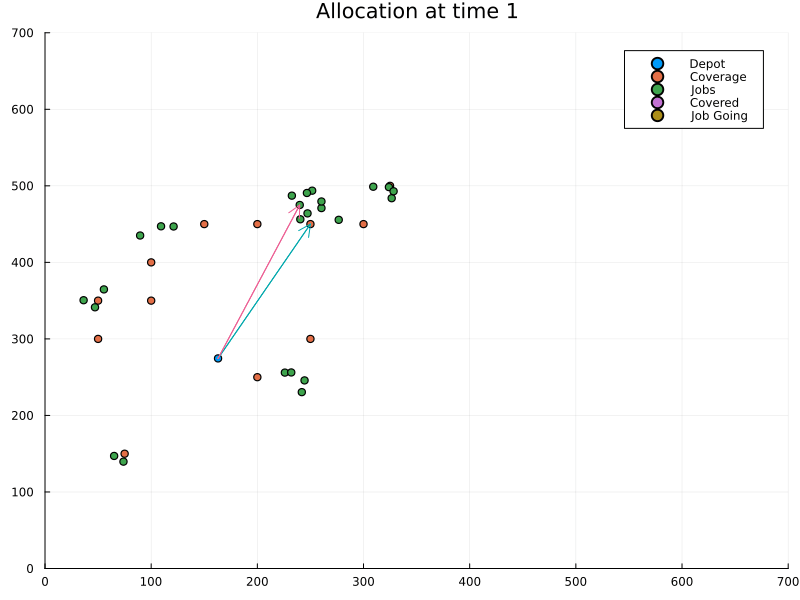

In [56]:
anim = @animate for t in 1:(T-1)
    u_cov, v_cov = [], []
    starts_cov_x, starts_cov_y = [], []
    
    for k in 1:n_vehicles_coverage
        for arc in coverage_drivers[k]
            if arc[1][2] == t
                node_start, node_end = arc[1][1], arc[2][1]
                start_x, start_y = coverage_locations[node_start + 1]
                if node_end == n_cov
                    fin_x, fin_y = coverage_locations[1]
                else
                    fin_x, fin_y = coverage_locations[node_end + 1]
                end
                push!(starts_cov_x, start_x)
                push!(starts_cov_y, start_y)
                push!(u_cov, fin_x - start_x)
                push!(v_cov, fin_y - start_y)
            end
        end
    end
    
    u_jobs, v_jobs = [], []
    starts_jobs_x, starts_jobs_y = [], []
    
    for k in 1:n_vehicles_jobs
        for arc in jobs_drivers[k]
            if arc[1][2] == t
                node_start, node_end = arc[1][1], arc[2][1]
                start_x, start_y = locations[node_start + 1, :]
                if node_end == n_jobs + 1
                    fin_x, fin_y = locations[1, :]
                else
                    fin_x, fin_y = locations[node_end + 1, :]
                end
                push!(starts_jobs_x, start_x)
                push!(starts_jobs_y, start_y)
                push!(u_jobs, fin_x - start_x)
                push!(v_jobs, fin_y - start_y)
            end
        end
    end
    
    jobs_going = []
    for i in 1:n_jobs
        if t in time_jobs[i]
            push!(jobs_going, i)
        end
    end
    
    cov_going = []
    for i in 1:(n_cov-1)
        if t in time_coverage[i]
            push!(cov_going, i)
        end
    end
            
    title_t = "Allocation at time "*string(t)

    scatter([[locations[1,1]], [coverage_locations[i][1] for i in 2:n_cov], [locations[2:(n_jobs+1), 1]], 
            [coverage_locations[i+1][1] for i in cov_going], [locations[i+1, 1] for i in jobs_going]],
            [[locations[1,2]], [coverage_locations[i][2] for i in 2:n_cov], [locations[2:(n_jobs+1), 2],
            [coverage_locations[i+1][2] for i in cov_going], [locations[i+1, 2] for i in jobs_going]],], 
            title = title_t, label = ["Depot" "Coverage" "Jobs" "Covered" "Job Going"], 
            xlim = (0,700), ylim = (0,700), size = (800,600), xticks = 0:100:700, yticks = 0:100:700)

    quiver!(starts_cov_x, starts_cov_y, quiver=(u_cov, v_cov))
    quiver!(starts_jobs_x, starts_jobs_y, quiver=(u_jobs, v_jobs))
end

gif(anim, "25.gif", fps = 1)

How many coverage vehicles did we need total? (could also compute from earlier)

In [57]:
coverage_needed = 0
for k in 1:n_vehicles_coverage
    if length(coverage_drivers[k]) > 1
        #println(k)
        coverage_needed += 1
    end
end
println("Number of coverage vehicles needed: ", coverage_needed)

Number of coverage vehicles needed: 6


How many job vehicles did we need? (could also compute from earlier)

In [58]:
jobs_needed = 0
for k in 1:n_vehicles_jobs
    if length(jobs_drivers[k]) > 1
        #println(k)
        jobs_needed += 1
    end
end
println("Number of jobs vehicles needed: ", jobs_needed)

Number of jobs vehicles needed: 7


# [4] Setup for Set Partitioning Methods

## [4a] Build Auxiliary Functions

Helper functions to find jobs given a route

In [59]:
function find_jobs(route)
    #=
    Given a route, which is a list of arcs, 
    return the job locations which are visited
    by that arc.
    =#
    jobs_route = []
    
    for n in 1:n_jobs
        
        for a in route
            if (n == a[1][1]) | (n == a[2][1])
                push!(jobs_route, n)
                break
            end
        end
        
    end
    
    return jobs_route
end

find_jobs (generic function with 1 method)

Let's test `find_jobs` with an example.

In [60]:
route_dummy = [ 
    [ [0, 0], [4, 5], 25.23],
    [ [4, 5], [5, 16], 24.12],
    [ [5, 16], [7, 24], 56.35],
    [ [7, 24], [16, 48], 0],
]

println(find_jobs(route_dummy))

Any[4, 5, 7, 16]


In [61]:
function find_jobs_time(route)
    #=
    Given a route, which is a list of arcs,
    return the [job number, time] tuple
    visited by the arc.
    
    Assumption: the route description is full.
    
    For example, if my arc has a "lapse" in time and looks like
    ...
    [ [5, 16], [7, 24], 56.35],
    [ [7, 24], [7, 38], 0],
    [ [7, 38], [16, 48], 0],
    ...
    
    then it will return [7, 24] only without [7, 25]...
    =#
    jobs_time_route = []
    
    #=
    There are two ways to do this.
    One: given the routes, iterate through routes and add through arrays as necessary.
    Two: given routes, iterate through jobs, times, and then arcs in route to match the jobs and times.
    =#
    for n in 1:n_jobs
        for t in 1:T
            for a in route
                #=
                If a job is performed in an arc we require:
                [ [job_loc, time_specified], [job_loc, ?], ?]
                =#
                if (n == a[1][1]) & (n == a[2][1]) & (t == a[1][2])
                    push!(jobs_time_route, [n,t])
                end
            end
        end
    end
    return jobs_time_route
end

find_jobs_time (generic function with 1 method)

Let's test `find_jobs_time` with an example.

In [62]:
route_dummy_time = [ 
    [ [0, 0], [4, 5], 25.23],
    [ [4, 5], [4, 12], 0],
    [ [4, 12], [5, 16], 213.24],
    [ [5, 16], [7, 24], 56.35],
    [ [7, 24], [7, 38], 0],
    [ [7, 38], [16, 48], 0],
]

println(find_jobs_time(route_dummy_time)) #see comment in function

Any[[4, 5], [7, 24]]


## [4b] Variable Setup

Now the setup becomes a bit more complicated. We would like to initialize a few variables for the set-partitioning formulation.

We set up an array of dummy routes. This corresponds to a basic set of columns (which will be used later in column generation).

Within this, we can also initialize two of the three additional variables <b>which need to be computed before we start the algorithm</b>.

-based off JOB variables-
One of them is delta, which operates on nodes (or $i$'s and $t$'s) and routes $q$. This tells us whether the route is at a certain node (location $i$ at time $t$) and is a binary indicator variable.

-based off JOB variables-
Another one is $u$, which tells us if route $q$ includes location $i$ at some point.

-based off COVERAGE variables-
The third one is based off the coverage and will be called $c$. If at time $t$, a route $r$ covers location $i$, then $c_{it}^r = 1$.

In [63]:
# Set up an initial route that is feasible.
dummy_route = []

#also initialize the two variables which we will need: u and delta.
u = [[] for i in 1:n_jobs]
delta = [[[] for t in 1:T] for i in 1:n_jobs]

# This is our cost matrix. It is specific to routes from JOBS.
C = []

println("Initializing dummy route")
#=
Each dummy route will proceed as follows:
For each job, get a route that will go from the depot
to the job number specified, then come back to the depot.
=#
for n in 1:n_jobs
    
    job_route = []
    cost_route = 0
    
    #= remember the distances variable we set all the way back
    in section 1b? That measured the distances between
    location a and location b.
    
    Watch out for the indices! In fact, we need to increment by 1 because
    index 1 refers to location 0 (depot), so job n has index n+1.
    =#
    dist = distances[1, n+1]
    
    #=
    Compute the times for which the vehicle stays at the job.
    
    The time at which the vehicle reaches the job? You need to first extract
    the start at which the vehicle can go to the job. Then, how long it takes
    to get there, and subtract the distance.
    
    The discretization of time makes it more accessible for integer measures.
    
    Remember: time_windows is a list of tuples.
    =#
    min_t = Int(floor(time_windows[n][1] - dist/speed))
    max_t = Int(ceil(time_windows[n][2] + dist/speed))
    
    #= Push all appropriate arcs:
    
    first type is the arc that goes from the depot to the job location
    second type are arcs in between that need to be satisfied
    final type is the arc that goes from job location back to depot
    =#
    push!(job_route, [[0, min_t], [n, time_windows[n][1]], dist])
    cost_route += dist
    
    for t in time_windows[n][1]:(time_windows[n][2]-1)
        push!(job_route, [[n, t], [n, t+1], 0])
    end
    
    push!(job_route, [[n, time_windows[n][2]], [n_jobs+1, max_t],  dist])
    cost_route += dist
    
    #the entire route is finished and now we can push it into our array of routes.
    push!(dummy_route, job_route)
    
    #also the cost of the route is important to record
    push!(C, cost_route)
end

Initializing dummy route


Now that we have all our dummy routes, let's test a few.

In [64]:
dummy_route[12]

5-element Vector{Any}:
 Any[[0, 12], [12, 14], 226.9786895767818]
 Any[[12, 14], [12, 15], 0]
 Any[[12, 15], [12, 16], 0]
 Any[[12, 16], [12, 17], 0]
 Any[[12, 17], [26, 19], 226.9786895767818]

And let's also make a note of how many dummy routes we have.

In [65]:
n_routes = length(dummy_route)

25

Define additional computed variable $u$, for the jobs, if route $q$ passes by location $i$.

In [66]:
for route in dummy_route
    #tell us which jobs are included in the route
    jobs_route = find_jobs(route)
    for n in 1:n_jobs
        if n in jobs_route
            push!(u[n], 1)
        else
            push!(u[n], 0)
        end
    end
end

In [67]:
for col in u
    println(col)
end

Any[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

NOTE: `u` is a two dimensional array. The first index in gives us the job number, $i$. Each element is then itself a list of whether the route number $q$ passes into $u$.

So indices would be called like $u_i^q =$ `u[i][q]`.

Define additional computed variable delta, for the jobs, if route $q$ is at location $i$ at time $t$.

In [68]:
for route in dummy_route
    jobs_time_route = find_jobs_time(route)
    for n in 1:n_jobs
        for t in 1:T
            if [n,t] in jobs_time_route
                push!(delta[n][t], 1)
            else
                push!(delta[n][t], 0)
            end
        end
    end
end

NOTE: delta here is defined as a three-dimensional array. The first index gives us the job number $i$. The second index gives us the time $t$. It is useful to call it as `delta[i][t]`, which then gives us a list itself, which is indexed based on route number. So to obtain information we call $\delta_{it}^q =$ `delta[i][t][q]`.

In [69]:
for job in 1:n_jobs
    for time in 1:T
        println("delta at job $(job) and time $(time) is $(delta[job][time])")
    end
    println()
end

delta at job 1 and time 1 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 2 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 3 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 4 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 5 is Any[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 6 is Any[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 7 is Any[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 8 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 9 is Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
delta at job 1 and time 10 i

Here's an example function test for `find_jobs_time`.

In [70]:
find_jobs_time(dummy_route[12])

3-element Vector{Any}:
 [12, 14]
 [12, 15]
 [12, 16]

Sure enough, if we look all the way back at the end of 3b (right before the start of 3c), we see that the job was worked on from times 14 to 16 inclusive.

Let's get our cost matrix for the routes. $C$ is a list, and we can access it by calling upon the subscript of the routes, like `C[q]`.

In [71]:
println(C)

Any[361.5131078586466, 354.7607228525183, 353.10378949077875, 551.3295353740317, 531.2484027487131, 547.8222795613261, 535.4831571042829, 295.4058184161513, 267.53597105125175, 280.6211233978089, 438.41682745364176, 453.9573791535636, 414.7573481083469, 395.21251480122766, 427.55843494085997, 429.4361382566155, 472.802937487361, 463.5797246987937, 447.448081690596, 172.79414039862428, 131.24480208871682, 142.68391763546433, 180.73953185215296, 323.26311497669536, 321.3796738868819]


## [4c] Label-Setting Algorithm

We create an algorithm for shortest paths.

<b>I'd like some help here.</b>

What is the LSA in a greater context, what does it do, how is it useful?

In [72]:
function label_setting(n, travel_time, travel_distance, windows, load)
    N = [[1]] 
    T = [0.0] 
    C = [0.0]  
    
    L = [1]    
    A = [true] 
    
    #=
    Need to add a new array of costs for the real costs.
    
    We have the reduced costs, which we explained...
    
    ...but there are also the 
    =#
    current_state = 1
    total_state = 1
    
    while 1==1
        if (L[current_state] == n+2) | (~A[current_state])
            current_state += 1
            if current_state > total_state
                break
            else
                continue
            end
        end
    
        #=
        For the moment, assume that we do not split time for jobs.
        =#
        
        for i in 2:(n+2)
            if ~(i in N[current_state])
                #If you won't have the time to do the job, don't go through it
                if L[current_state] != 1
                    if T[current_state] + load[L[current_state]-1] + travel_time[L[current_state], i] > windows[i-1][2] - load[i-1]
                        continue
                    end
                end
                
                #Check if you have already created a path
                if length(N) < total_state + 1   #If not, add it
                    push!(N, copy(N[current_state]))
                    push!(N[total_state+1], i)
                    push!(T, max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1]))
                    push!(C, C[current_state] + travel_distance[L[current_state], i])
                    push!(L, i)
                    push!(A, true)
                else  #Otherwise, change it
                    N[total_state + 1] = N[current_state]
                    push!(N[total_state+1], i)
                    T[total_state+1] = max(T[current_state] + travel_time[L[current_state], i], windows[i-1][1])
                    C[total_state+1] = C[current_state] + travel_distance[L[current_state], i]
                    #What I did to create the path also follows for what I do to change the path.
                    #TODO
                    L[total_state+1] = i
                    A[total_state+1] = true
                end 
                
                NDom = true
                for s in 1:total_state
                    if A[s]
                        if (issetequal(N[total_state+1], N[s])) & (L[total_state+1] == L[s])
                            if C[total_state+1] > C[s]   #the new state is dominated by at least one state so we can stop
                                NDom = false
                                break
                            else   #the new state dominates the old one so we can get rid of it
                                A[s] = false
                            end
                        end
                    end
                end
                
                if NDom  #Means that the new state dominates all the other, so we go on to create the next state
                    total_state += 1
                end
        
            end
        end
        current_state += 1
        if current_state == total_state
            break
        end     
    end
    return N, A, C, T
end

label_setting (generic function with 1 method)

In [73]:
distances_label = deepcopy(distances)
add = distances_label[1,:]
distances_label = hcat(distances_label, add)
push!(add, 0)
distances_label = vcat(distances_label, collect(add'))

load_label = deepcopy(work_load)
push!(load_label, 0)

windows_label = deepcopy(time_windows)
push!(windows_label, [0,100])

travel = ceil.(distances_label/speed);

Let's see what they look like...

`n_jobs` is the number of jobs we have.

In [74]:
print(n_jobs)

25

`travel` is a matrix representing how much time it takes to get from one location to another.

In [75]:
travel

27×27 Matrix{Float64}:
 0.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 2.0  0.0  1.0  1.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  1.0  0.0  1.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  1.0  1.0  0.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  0.0  1.0  1.0  1.0     2.0  2.0  2.0  2.0  3.0  3.0  2.0
 2.0  2.0  2.0  2.0  1.0  0.0  1.0  1.0  …  2.0  2.0  2.0  2.0  3.0  3.0  2.0
 2.0  2.0  2.0  2.0  1.0  1.0  0.0  1.0     2.0  2.0  2.0  2.0  3.0  3.0  2.0
 2.0  2.0  2.0  2.0  1.0  1.0  1.0  0.0     2.0  2.0  2.0  2.0  3.0  3.0  2.0
 1.0  1.0  1.0  1.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  1.0
 1.0  1.0  1.0  1.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  1.0
 1.0  1.0  1.0  1.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  1.0
 2.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0     2.0  2.0  2.0  2.0  3.0  3.0  2.0
 2.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  

`windows_label` is our time windows.

In [76]:
print(windows_label)

Any[[5, 8], [13, 17], [20, 25], [8, 10], [14, 17], [22, 26], [30, 35], [2, 8], [11, 14], [18, 22], [9, 13], [14, 17], [21, 24], [27, 29], [31, 37], [2, 5], [8, 10], [12, 17], [17, 21], [10, 14], [15, 20], [24, 27], [27, 33], [4, 9], [9, 15], [0, 100]]

`load_label` is our required time to work on each job.

In [77]:
print(load_label)

Any[3, 4, 5, 2, 2, 3, 4, 3, 2, 4, 4, 3, 3, 2, 5, 3, 2, 3, 3, 3, 4, 2, 3, 4, 5, 0]

# <b>QUESTION:</b> Why do we need the `[0, 100]` at the end? What is that supposed to signify?

Performing label-setting will take significant time. We'll include a time elapsed to measure.

Meanwhile, we gather four variables with this function:
    
- the routes we will use
- whether a route is feasible or not
- the costs associated with the routes
- times of arrival

In [78]:
time = @elapsed routes, feasible, cost, times = label_setting(n_jobs, travel, distances_label, windows_label, load_label);

Oof. I uncovered an error in the generation of clusters all the way back...

In [79]:
time

82.832106322

## [4d] Retrieve Variables as Necessary

We will get `C_routes` and `T_routes`.

`C_routes` signifies the cost of a route for a JOB VEHICLE to handle. This is equivalent to $C^q$ in the formulation.

`T_routes` signifies how long it takes to perform each route.

In [380]:
routes_keep = []
C_routes = []
T_routes = []

#=
Loop over all routes.

For each route, if it is feasible and ends back in the depot, 
store the cost of that route in C_routes.
Similarly, store time in T_routes.
=#
for r in 1:length(routes)
    if (last(routes[r]) == n_jobs+2) & (feasible[r])
        push!(routes_keep, routes[r] .- 1)
        push!(C_routes, cost[r])
        push!(T_routes, times[r])
    end
end

View `C_routes`. This should be a long list.

In [381]:
C_routes

9381-element Vector{Any}:
    0.0
  361.5131078586466
  354.7607228525183
  353.10378949077875
  551.3295353740317
  531.2484027487131
  547.8222795613261
  535.4831571042829
  295.4058184161513
  267.53597105125175
  280.6211233978089
  438.41682745364176
  453.9573791535636
    ⋮
 1414.1849000348939
 1315.6045846842694
 1730.5688226886073
 1728.06940708475
 1777.8972740566433
 1439.2755464156135
 1340.695231064989
 1713.4651585413908
 1285.8530318221412
 1187.2727164715168
 1602.2369544758549
 1599.7375388719972

View `T_routes`. This should have the same length as `C_routes`. Times should be integer because time is discretized.

In [82]:
T_routes

9381-element Vector{Any}:
  0.0
  7.0
 15.0
 22.0
 10.0
 16.0
 24.0
 32.0
  3.0
 12.0
 19.0
 11.0
 16.0
  ⋮
 32.0
 33.0
 33.0
 33.0
 33.0
 32.0
 33.0
 33.0
 32.0
 33.0
 33.0
 33.0

Update the variable `n_routes`, as it is no longer 25.

In [83]:
n_routes = length(routes_keep);
print(n_routes)

9381

### Which jobs does each route cover?

In [84]:
u = [[0 for i in 1:n_jobs] for r in 1:n_routes]
for r in 1:n_routes
    for i in 1:n_jobs
        if i in routes_keep[r]
            u[r][i] = 1
        end
    end
end

### Compute the time of arrival at each locations

In [85]:
#Time of arrival at each job locations
routes_times = [[0.0 for i in 1:length(routes_keep[r])] for r in 1:length(routes_keep)]

for r in 1:length(routes_keep)
    for i in 2:length(routes_keep[r])
        t_1 = routes_times[r][i-1]
        loc_1 = routes_keep[r][i-1]
        if loc_1 == 0
            load_1 = 0
        else
            load_1 = work_load[loc_1]
        end
        loc = routes_keep[r][i]
        t_work_travel = t_1 + load_1 + travel[loc_1 + 1, loc + 1]
        min_t = max(t_work_travel, windows_label[loc][1])
        routes_times[r][i] = min_t
    end
end

### Discretize the time for each job and each route

In [86]:
routes_job_time = [[[0.0 for t in 1:T] for i in 1:n_jobs] for r in 1:length(routes_keep)]
for r in 1:length(routes_keep)
    for i in 1:n_jobs
        if i in routes_keep[r]
            index = findall(x->x==i, routes_keep[r])[1]
            t_start = Int(routes_times[r][index])
            t_end = Int(t_start + work_load[i])
            for t in t_start:t_end
                routes_job_time[r][i][t] = 1
            end
        end
    end
end

In [87]:
routes_job_time

9381-element Vector{Vector{Vector{Float64}}}:
 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0

# [5] Model with Set-Partitioning for Jobs

Constructing the set-partitioning formulation in line with pages 5-6.

In [88]:
model_set = Model(Gurobi.Optimizer);
#model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=100));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


## [5a] Decision Variables

We have our primary decision variables of $x_{rk}$ and $z_{kq}$.

$z_{kq}$ represents whether TASK driver $k$ uses route $q$. The range for this is: for variable $k$, from `1` to `n_vehicles_jobs`, and for $q$, this goes up to `n_routes`.

$x_{kr}$ represents whether COVERAGE driver $k$ uses route $r$. The range goes from `1` to `n_vehicles_jobs` for variable $k$, and for $r$, we are looking at routes which is still all the way back at `A_cov`.

Then we have our $y^S$ and $y^E$, I'll copy their descriptions from the previous direct formulation:

Job start and end times: $y^S_{it}$/$y_{it}^E$ with $1$ if a job's start/end has taken place by that time (so this is an array like \[ 0, 0, ...., 1, 1, ..., 1\] and the differential will tell us when the job is taking place, it will look like \[ 0, 0, ..., 1, 1, ..., 0, 0\]

And then there's gamma.

In [89]:
#Coverage vehicles
@variable(model_set, x[1:n_vehicles_coverage, 1:A_cov], Bin)
#Job Vehicles
@variable(model_set, z[1:n_vehicles_jobs, 1:n_routes], Bin)
#Starting and ending times of each Job
@variable(model_set, y_s[1:n_jobs, 1:T], Bin)
@variable(model_set, y_e[1:n_jobs, 1:T], Bin)
#Coverage constraint
@variable(model_set, gamma[1:N], Bin);

## [5b] Objective

This is equation 21 in the ICT sheet (page 5).

We want to minimize total costs. This will be a sum of two terms:

For JOB vehicles: For all $k \in \mathcal{K}$ and for all routes $q \in \mathcal{Q}$, take the cost of that proposed route times whether that route is traveled: it's $\sum_{k \in \mathcal{K}} \sum_{q \in \mathcal{Q}} C^q z_q^k$.

To actualize this: Not much to do it's right there; use `C_routes` for cost of routes for JOB vehicles.

For COVERAGE vehicles: Similar situation.

To actualize this: Right now, we are dealing with arcs instead of 'true routes'. So to find the distance, we look at `arcs_cov[3]`.

In [90]:
@objective(model_set, 
    Min, 
    sum(sum(x[k,a]*(arcs_cov[a][3]+1) for a in 1:A_cov) for k in 1:n_vehicles_coverage) 
    + sum(sum(z[k,q]*C_routes[q] for q in 1:n_routes) for k in 1:n_vehicles_jobs))
;

## [5c] Constraints

### Each job is only done once

Look at JOB vehicles. Summing up over all routes and drivers, only one driver should use the route, and that route passes by that job, so it's a sum over $u_i^q z_q^k$.

In [91]:
@constraint(model_set, 
    unique[i in 1:n_jobs],
    sum(sum(z[k,q]*u[q][i] for q in 1:n_routes) for k in 1:n_vehicles_jobs) == 1);


### Each driver is assigned to exactly one route

For each JOB vehicle: 1 route out of all within $\mathcal{Q}$ is used.

In [92]:
@constraint(model_set, 
    driver[k in 1:n_vehicles_jobs], 
    sum(z[k,q] for q in 1:n_routes) == 1);

### Coverage Vehicles constraints

The constraints which we used for the direct formulation on coverage vehicles specifically hold here.

In [93]:
@constraint(model_set, depot_init_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1][1] == 0) == 1)
@constraint(model_set, depot_end_coverage[k in 1:n_vehicles_coverage], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2][1] == n_cov) == 1)
@constraint(model_set, flow_coverage[k in 1:n_vehicles_coverage, n in 1:N_cov], sum(x[k,a] for a in 1:A_cov if arcs_cov[a][2] == nodes_cov[n]) == sum(x[k,a] for a in 1:A_cov if arcs_cov[a][1] == nodes_cov[n]))
;

### Time constraints

Similar to direct formulation, not much to say.

In [94]:
#takes a VERY long time!

@constraint(model_set, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(model_set, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
@constraint(model_set, work[i in 1:n_jobs, t in 2:(T-2)], y_s[i,t] - y_e[i,t] <= sum(sum(z[k,q]*routes_job_time[q][i][t] for q in 1:n_routes) for k in 1:n_vehicles_jobs))
@constraint(model_set, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] <= 0)
@constraint(model_set, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] >= 1)
@constraint(model_set, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
;

### Coverage constraint

The coverage constraint ensures that if a route is not covered at a particular time (RHS), then it's meaningless for routes to pass through that job location (LHS). In other words, the $\leq$ sign guarantees that if RHS is zero, then LHS must also be zero.

First there's a node-finding equation which will be needed to extract the appropriate nodes in an arc.

In [95]:
function find_node(i,t)
    for node in 1:length(nodes)
        if (nodes[node][1] == i) & (nodes[node][2] == t) 
            return node
        end
    end
    return "Warning, this node does not exist"
end

find_node (generic function with 1 method)

In [96]:
# takes a long time!

@constraint(model_set, 
    coverage[i in 1:n_jobs, t in 2:(T-1)],
    sum(sum(z[k,q]*routes_job_time[q][i][t] for q in 1:n_routes) for k in 1:n_vehicles_jobs) 
    <= sum(sum(x[k,a] for a in covers[find_node(i,t)]) for k in 1:n_vehicles_coverage))
print()

Optimize the model. Should give us a better objective than the direct formulation.

In [199]:
optimize!(model_set)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10595 rows, 214050 columns and 6429920 nonzeros
Model fingerprint: 0x720602c2
Variable types: 0 continuous, 214050 integer (214050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolved: 5111 rows, 191526 columns, 981722 nonzeros

Continuing optimization...


Explored 1 nodes (6294 simplex iterations) in 0.77 seconds (0.75 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 4993.13 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.993131455454e+03, best bound 4.993131455454e+03, gap 0.0000%

User-callback calls 287, time in user-callback 0.00 sec


The answer we got here was

4993.13

which beats our direct formulation answer of

5151.13

## [5d] Extract useful information

If there's a route which we've used, then it will be useful. Let's get all of them.

In [98]:
useful_routes = []
for r in 1:n_routes
    for k in 1:n_vehicles_jobs
        if value.(z[k,r]) > 1e-5
            push!(useful_routes, r)
        end
    end
end

Which are they?

In [99]:
for r in useful_routes
    println("A useful route is $(routes_keep[r])")
end

A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 26]
A useful route is [0, 24, 25, 26]
A useful route is [0, 1, 2, 3, 26]
A useful route is [0, 8, 9, 10, 26]
A useful route is [0, 11, 12, 15, 26]
A useful route is [0, 4, 5, 6, 7, 26]
A useful route is [0, 20, 21, 22, 23, 26]
A useful route is [0, 16, 17, 18, 19, 13, 14, 26]


# [6] Pre-compute for column generation

## [6.1] Get Parameters

### Compute $\delta_{it}^q$

In [237]:
function compute_delta(routes)
    Q = length(routes)
    delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1, time1 = arc[1]
            loc2, time2 = arc[2]
            if (loc1 != 0) & (loc1 != n_jobs + 1)
                delta[loc1][time1][rindex] = 1
            end
            
            if (loc2 != 0) & (loc2 != n_jobs + 1)
                delta[loc2][time2][rindex] = 1
            end
        end
    end
    return delta
end
        

compute_delta (generic function with 1 method)

In [238]:
print(dummy_route[8])

Any[Any[[0, 1], [8, 2], 147.70290920807565], Any[[8, 2], [8, 3], 0], Any[[8, 3], [8, 4], 0], Any[[8, 4], [8, 5], 0], Any[[8, 5], [8, 6], 0], Any[[8, 6], [8, 7], 0], Any[[8, 7], [8, 8], 0], Any[[8, 8], [26, 9], 147.70290920807565]]

In [449]:
delta = compute_delta(dummy_route)
println(delta[8][6][8])

1.0


### Compute $u_i^q$

In [240]:
function compute_u(routes)
    Q = length(routes)
    u = [[0 for q in 1:Q] for i in 1:n_jobs]
    
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1 = arc[1][1]
            loc2 = arc[2][1]
            if (1 <= loc1 <= n_jobs)
                u[loc1][rindex] = 1
            end
            if (1 <= loc2 <= n_jobs)
                u[loc2][rindex] = 1
            end
        end
    end
    return u
end
                

compute_u (generic function with 1 method)

In [448]:
u = compute_u(dummy_route)

25-element Vector{Vector{Int64}}:
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 

### Compute cost of route

In [254]:
function route_cost(route)
    distance = 0
    for arc in route
        distance += arc[3]
    end
    return distance
end

route_cost (generic function with 1 method)

In [255]:
route_cost(dummy_route[1])

361.5131078586466

# [7] Column Generation

## WARNING

The dummy routes provided are actually NOT feasible. If we have 25 routes, each of which visits one job, we need at least 25 vehicles. But we actually don't have 25 vehicles, we have 15!

So I'm going to temporarily increase `n_vehicles_jobs` to 25.

## [7.1] Setup Model

In [382]:
n_vehicles_jobs = 25

25

Goal: Start with our dummy routes. On the master problem side, first we solve the instance with just the dummy routes. 

In [383]:
Q = length(dummy_route)

25

In [397]:
modelcg = Model(Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

### Decision variables

$z^q$ as to whether or not a route is actually used

$y_{it}^S$ if a job at location $i$ starts by time $t$

$y_{it}^E$ if a job at location $i$ is ended by time $t$

In [398]:
unregister(modelcg, :z)
unregister(modelcg, :y_s)
unregister(modelcg, :y_e)
@variable(modelcg, z[1:Q], Bin)
@variable(modelcg, y_s[1:n_jobs, 1:T], Bin)
@variable(modelcg, y_e[1:n_jobs, 1:T], Bin)
print()

### Constraint: Each job is taken exactly once

We have $\sum_{q \in \mathcal{Q}} u_i^q z^q = 1 \ \forall i \in \mathcal{I}$

In [399]:
unregister(modelcg, :unique)
@constraint(modelcg, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) == 1)
print()

### Constraint: there are at most as many routes as there are drivers

In [400]:
unregister(modelcg, :driver)
@constraint(modelcg, driver, sum(z[q] for q in 1:Q) <= n_vehicles_jobs)
print()

### Time Constraints

In [401]:
unregister(modelcg, :start)
unregister(modelcg, :ends)
@constraint(modelcg, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(modelcg, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
print()

In [402]:
unregister(modelcg, :window_start)
unregister(modelcg, :window_ends)
@constraint(modelcg, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] == 0)
@constraint(modelcg, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] == 1)
print()

In [403]:
unregister(modelcg, :duration)
@constraint(modelcg, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
print()

In [404]:
unregister(modelcg, :work)
@constraint(modelcg, work[i in 1:n_jobs, t in 1:(T-1)], 
    y_s[i, t] - y_e[i, t] <= sum(z[q] * delta[i][t][q] for q in 1:Q), base_name = "working")
print()

In [405]:
@constraint(modelcg, coverage[i in 1:n_jobs, t in 1:T], y_s[i, t] - y_e[i, t] <= 1)

25×45 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 coverage[1,1] : y_s[1,1] - y_e[1,1] ≤ 1.0     …  coverage[1,45] : y_s[1,45] - y_e[1,45] ≤ 1.0
 coverage[2,1] : y_s[2,1] - y_e[2,1] ≤ 1.0        coverage[2,45] : y_s[2,45] - y_e[2,45] ≤ 1.0
 coverage[3,1] : y_s[3,1] - y_e[3,1] ≤ 1.0        coverage[3,45] : y_s[3,45] - y_e[3,45] ≤ 1.0
 coverage[4,1] : y_s[4,1] - y_e[4,1] ≤ 1.0        coverage[4,45] : y_s[4,45] - y_e[4,45] ≤ 1.0
 coverage[5,1] : y_s[5,1] - y_e[5,1] ≤ 1.0        coverage[5,45] : y_s[5,45] - y_e[5,45] ≤ 1.0
 coverage[6,1] : y_s[6,1] - y_e[6,1] ≤ 1.0     …  coverage[6,45] : y_s[6,45] - y_e[6,45] ≤ 1.0
 coverage[7,1] : y_s[7,1] - y_e[7,1] ≤ 1.0        coverage[7,45] : y_s[7,45] - y_e[7,45] ≤ 1.0
 coverage[8,1] : y_s[8,1] - y_e[8,1] ≤ 1.0        coverage[8,45] : y_s[8,45] - y_e[8,45] ≤ 1.0
 coverage[9,1] : y_s[9,1] - y_e[9,1] ≤ 1.0        coverage[9,45] : y_s[9,

### Objective

In [406]:
@objective(modelcg, Min, sum(route_cost(dummy_route[q]) * z[q] for q in 1:Q))

361.5131078586466 z[1] + 354.7607228525183 z[2] + 353.10378949077875 z[3] + 551.3295353740317 z[4] + 531.2484027487131 z[5] + 547.8222795613261 z[6] + 535.4831571042829 z[7] + 295.4058184161513 z[8] + 267.53597105125175 z[9] + 280.6211233978089 z[10] + 438.41682745364176 z[11] + 453.9573791535636 z[12] + 414.7573481083469 z[13] + 395.21251480122766 z[14] + 427.55843494085997 z[15] + 429.4361382566155 z[16] + 472.802937487361 z[17] + 463.5797246987937 z[18] + 447.448081690596 z[19] + 172.79414039862428 z[20] + 131.24480208871682 z[21] + 142.68391763546433 z[22] + 180.73953185215296 z[23] + 323.26311497669536 z[24] + 321.3796738868819 z[25]

## [7.2] Solve model for the first time

In [407]:
optimize!(modelcg)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5501 rows, 2275 columns and 12300 nonzeros
Model fingerprint: 0x031af9ac
Variable types: 0 continuous, 2275 integer (2275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 9294.0984753
Presolve removed 5501 rows and 2275 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 9294.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.294098475285e+03, best bound 9.294098475285e+03, gap 0.0000%

User-callback calls 1242, time in user-callback 0.00 sec


In [396]:
dual_status(modelcg)

NO_SOLUTION::ResultStatusCode = 0

In [377]:
dual.(work)

LoadError: Gurobi Error 10005: Unable to retrieve attribute 'Pi'

In [379]:
println(constraint_by_name(modelcg, "working").Pi)

LoadError: type Nothing has no field Pi

## [7.3] Solve dual and extract dual variables

Unfortunately, unlike the cutting stock example, this is not one of those problems where the dual variables can simply be thrown at us by Gurobi. Instead, we will need to compute the dual and see where it leads us.

See my document https://github.com/DA72p/ict-opt/blob/main/gathering-the-dual.pdf for my approach and equations in the dual.

In [500]:
modual = Model(Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

In [501]:
@variable(modual, pi[1:n_jobs])
@variable(modual, rho >= 0)
@variable(modual, alpha[1:n_jobs, 1:T] >= 0)
@variable(modual, beta[1:n_jobs, 1:T] >= 0)
@variable(modual, zeta[1:n_jobs, 1:T] >= 0)
@variable(modual, eta[1:n_jobs, 1:T])
@variable(modual, mu[1:n_jobs, 1:T] >= 0)
@variable(modual, theta[1:n_jobs] >= 0)
print()

In [502]:
@constraint(modual, routing[q in 1:Q], 
    sum(pi[i] * u[i][q] for i in 1:n_jobs)
    + rho 
    + sum(sum( mu[i, t] * delta[i][t][q] for i in 1:n_jobs) for t in 1:T) <= C[q])
print()

In [503]:
for i in 1:n_jobs
    for t in 1:T
        if t == 1
            if t <= time_windows[i][1]
                @constraint(modual, [1:2], -alpha[i, t] + zeta[i, t] - mu[i, t] + theta[i] <= 0)
            else
                println("The impossible case 2 has happened!")
                @constraint(modual, [1:2], -alpha[i, t] - mu[i, t] + theta[i] <= 0)
                @constraint(modual, [1:2], zeta[i, t] == 0)
            end
        end
        if 2 <= t <= T - 1
            if t <= time_windows[i][1]
                @constraint(modual, [1:2], alpha[i, t-1] - alpha[i, t] + zeta[i, t] - mu[i, t] + theta[i] <= 0)
            else
                @constraint(modual, [1:2], alpha[i, t-1] - alpha[i, t] - mu[i, t] + theta[i] <= 0)
                @constraint(modual, [1:2], zeta[i, t] == 0)
            end
        end
        if t == T
            if t <= time_windows[i][1]
                println("The impossible case 5 has happened!")
                @constraint(modual, [1:2], alpha[i, t-1] + zeta[i, t] - mu[i, t] + theta[i] <= 0)
            else
                @constraint(modual, [1:2], alpha[i, t-1] - mu[i, t] + theta[i] <= 0)
                @constraint(modual, [1:2], zeta[i, t] == 0)
            end
        end
    end
end

In [504]:
for i in 1:n_jobs
    for t in 1:T
        if t == 1
            if t >= time_windows[i][2]
                println("The impossible case 1 has happened!")
                @constraint(modual, [1:2], -beta[i, t] + eta[i, t] + mu[i, t] - theta[i] <= 0)
            else
                @constraint(modual, [1:2], -beta[i, t] + mu[i, t] - theta[i] <= 0)
                @constraint(modual, [1:2], eta[i, t] == 0)
            end
        end
        if 2 <= t <= T - 1
            if t >= time_windows[i][2]
                @constraint(modual, [1:2], beta[i, t-1] - beta[i, t] + eta[i, t] + mu[i, t] - theta[i] <= 0)
            else
                @constraint(modual, [1:2], beta[i, t-1] - beta[i, t] + mu[i, t] - theta[i] <= 0)
                @constraint(modual, [1:2], eta[i, t] == 0)
            end
        end
        if t == T
            if t >= time_windows[i][2]
                @constraint(modual, [1:2], beta[i, t-1] + eta[i, t] + mu[i, t] - theta[i] <= 0)
            else
                println("The impossible case 6 has happened!")
                @constraint(modual, [1:2], beta[i, t-1] + mu[i, t] - theta[i] <= 0)
                @constraint(modual, [1:2], eta[i, t] == 0)
            end
        end
    end
end

In [513]:
@objective(modual, Max, 
    sum(pi[i] for i in 1:n_jobs) 
    - n_vehicles_jobs * rho 
    + sum((eta[i, t] for t in 1:T) for i in 1:n_jobs) 
    + sum(work_load[i] * theta[i] for i in 1:n_jobs))
print()

In [514]:
optimize!(modual)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6925 rows, 5676 columns and 22475 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0000000e+30   2.085000e+32   8.000000e+00      0s
      17    9.2940985e+03   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.294098475e+03

User-callback calls 34, time in user-callback 0.00 sec


In [518]:
dual(routing[1])

-1.0